<a href="https://colab.research.google.com/github/hazhalim/social-media-mood-analyser/blob/main/Social_Media_Mood_Analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Social Media Mood Analyser**


# Loading of the base Hartmann (2022)'s *Emotion English DistilRoBERTa-base* Model

In [ ]:
# First, install the transformers library
# Comment the line below if this library has already been installed to save time
!pip install transformers

In [ ]:
# Import AutoTokenizer, AutoModelForSewquenceClassification classes from the transformers library
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Declare the base model's name (from Hugging Face)
base_model_name = "j-hartmann/emotion-english-distilroberta-base"

# Create the tokenizer from the pretrained base model
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Declare the model from the pretrained base model
model = AutoModelForSequenceClassification.from_pretrained(base_model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [ ]:
model.config.label2id

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [ ]:
model.config.id2label

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

# Loading and Data Preprocessing for Faraggi (2022)'s *Emotion Tweet intensity* dataset



In [ ]:
# Import the pandas library, since we need to upload the Emotion Tweet intensity dataset file
import pandas as pd

# Load the train and test datasets as a pandas DataFrame first
faraggi_train_df = pd.read_csv("faraggi_train.csv")
faraggi_test_df = pd.read_csv("faraggi_test.csv")

In [ ]:
# To confirm it's been loaded properly, we preview some of the rows of it
print(faraggi_train_df.head())

      id                                              tweet    class  \
0  40815  Loved @Bethenny independence msg on @WendyWill...     fear   
1  10128  @mark_slifer actually maybe we were supposed t...  sadness   
2  40476  I thought the nausea and headaches had passed ...     fear   
3  20813  Anger, resentment, and hatred are the destroye...    anger   
4  40796  new tires &amp; an alarm system on my car. fwm...     fear   

  sentiment_intensity class_intensity  labels  
0                 low        fear_low       4  
1                high    sadness_high       9  
2              medium     fear_medium       5  
3                high      anger_high       0  
4                 low        fear_low       4  


In [ ]:
# To confirm it's been loaded properly, we preview some of the rows of it
print(faraggi_test_df.head())

      id                                              tweet    class  \
0  31079  Rear garden alarm activated  at Telford house ...  sadness   
1  11428  @bt_uk appointment booked between 1-6 today, w...     fear   
2  21865  Hoping to hear some serious @DonnieTrumpet ton...     fear   
3  31125  I'm always smiling so that's why I'm always ha...  sadness   
4  30912  @Sirenja_ @JaxOfBo (like, hope i didn't offend...      joy   

   sentiment_intensity class_intensity  labels  
0                  NaN    sadness_NONE      -1  
1                  NaN       fear_NONE      -1  
2                  NaN       fear_NONE      -1  
3                  NaN    sadness_NONE      -1  
4                  NaN        joy_NONE      -1  


We only need the id, the tweet, the class, and labels columns, so we can drop the other columns to simply the datasets.

In [ ]:
# Drop unrequired columns in Faraggi datasets
faraggi_train_df = faraggi_train_df.drop(columns = ["sentiment_intensity", "class_intensity"])
faraggi_test_df = faraggi_test_df.drop(columns = ["sentiment_intensity", "class_intensity"])

Since we're using two source of datasets, it's best to standardise the column names. So, let's rename the columns so that they match each other.

In [ ]:
# Rename the columns to be standardised across both sources of datasets
faraggi_train_df = faraggi_train_df.rename(columns = {"tweet": "text", "labels": "label"})
faraggi_test_df = faraggi_test_df.rename(columns = {"tweet": "text", "labels": "label"})

In [ ]:
faraggi_test_df

id                                               text    class  label
0     31079  Rear garden alarm activated  at Telford house ...  sadness     -1
1     11428  @bt_uk appointment booked between 1-6 today, w...     fear     -1
2     21865  Hoping to hear some serious @DonnieTrumpet ton...     fear     -1
3     31125  I'm always smiling so that's why I'm always ha...  sadness     -1
4     30912  @Sirenja_ @JaxOfBo (like, hope i didn't offend...      joy     -1
...     ...                                                ...      ...    ...
3137  41297  The @Orioles are in contention and hosting @Re...     fear     -1
3138  21747                         I'm so over having anxiety    anger     -1
3139  31202  My son 11 has 128 friends on Facebook and yet ...  sadness     -1
3140  41285  Thorpe park fright night booked for me and @Ja...    anger     -1
3141  31132  ok so i got my madden 17 refunded but now i go...      joy     -1

[3142 rows x 4 columns]

On some rows, you can see weird characters, likely emojis translated into text. We should also remove any unwanted sections such as URLs, and normalise whitespace. We can do all of that with a text-cleaning helper function.

In [ ]:
# Import regex and string libraries
import re
import string

# Define the text-cleaning helper function
def clean_text(text):
    # Remove non-ASCII characters (emojis etc.) from texts
    text = text.encode("ascii", errors = "ignore").decode()

    # Remove any URLs from texts
    text = re.sub(r"http\S+", "", text)

    # Normalise the whitespace in texts
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
# Apply the text-cleaning in both dataset's text column for each row
for dataset in [faraggi_train_df, faraggi_test_df]:
    dataset["text"] = dataset["text"].apply(clean_text)

We can also notice that the labelling for these two datasets are all wrong. Let's remap them according to the base model's labelling, where:

0: anger 🤬

1: disgust 🤢

2: fear 😨

3: joy 😀

4: neutral 😐

5: sadness 😭

6: surprise 😲

We also need to keep in mind that for Faraggi's datasets, the emotions available are: fear, anger, joy, and sadness.

In [ ]:
# Define label mapping to fix the label in the Faraggi datasets
faraggi_label_mapping = {
    "fear": 2,
    "anger": 0,
    "joy": 3,
    "sadness": 5
}

In [ ]:
# Apply the mapping to the two datasets
for dataset in [faraggi_train_df, faraggi_test_df]:
    dataset["label"] = dataset["class"].map(faraggi_label_mapping)

Since we've finished mapping the labels to the correct labelling according to the base model, we don't require the class column anymore. To standardise the format of the datasets, we will drop this column.

In [ ]:
# Drop the class column in both datasets
faraggi_train_df = faraggi_train_df.drop(columns = ["class"])
faraggi_test_df = faraggi_test_df.drop(columns = ["class"])

Now that both train and test datasets have been cleaned properly, it's time to combine them together, and convert it into a Hugging Face-style dataset.

In [ ]:
# Combine the train and test datasets using pandas
faraggi_combined_df = pd.concat([faraggi_train_df, faraggi_test_df], ignore_index = True)

# Convert the combined pandas DataFrame into a Hugging Face-style dataset
# Import the Dataset class from the datasets library first
from datasets import Dataset

faraggi_dataset = Dataset.from_pandas(faraggi_combined_df)

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [ ]:
# Create a helper function to tokenize a dataset
def tokenize_dataset(dataset):
  return tokenizer(dataset["text"], padding = True, truncation = True)

Now, we tokenize the text column of the Faraggi dataset.

In [ ]:
# Tokenize the Faraggi dataset's text
tokenized_faraggi_dataset = faraggi_dataset.map(tokenize_dataset, batched = True)

Map:   0%|          | 0/7102 [00:00<?, ? examples/s]

# Loading and Data Preprocessing for Elgiriyewithana (2024)'s *Emotions* dataset

In [ ]:
# Load the dataset as a pandas DataFrame first
elgiriyewithana_df = pd.read_csv("elgiriyewithana_emotions.csv")

In [ ]:
# To confirm it's been loaded properly, we preview some of the rows of it
print(elgiriyewithana_df.head())

   id                                               text  label
0   0      i just feel really helpless and heavy hearted      4
1   1  ive enjoyed being able to slouch about relax a...      0
2   2  i gave up my internship with the dmrg and am f...      4
3   3                         i dont know i feel so lost      0
4   4  i am a kindergarten teacher and i am thoroughl...      4


In [ ]:
# Now, we convert the DataFrame to the Hugging Face-type dataset
elgiriyewithana_dataset = Dataset.from_pandas(elgiriyewithana_df)

The *Emotions* dataset only contains labelled text for sadness, joy, love, anger, fear, and surprise. While almost all emotions are compatible with the base Hartmann model, love is incompatible. Love is most similar to joy, but fundamentally, they are different since joy can include non-romantic contexts. Hence, we elect to exclude love as one of the emotions in the *Emotions* dataset.

In [ ]:
# Filter out the love emotion (text labelled '2' in the dataset)
elgiriyewithana_dataset = elgiriyewithana_dataset.filter(lambda x: x["label"] != 2)

Filter:   0%|          | 0/416809 [00:00<?, ? examples/s]

We need to convert the numbered labels from the Emotions dataset to match the label of the mapping. Then, we create a helper function to help us remap each row, then apply the remapping to the *Emotions* dataset.

In [ ]:
# Create the Elgiriyewithana-to-Base label mapping
label_mapping = {
    0: 5, # Sadness emotion
    1: 3, # Joy emotion
    3: 0, # Anger emotion
    4: 2, # Fear emotion
    5: 6  # Surprise emotion
}

# Create a helper function to remap the labels
def remap_elgiri_to_base_labels(entry):
  entry["label"] = label_mapping[entry["label"]]

  return entry

# Actually remap the dataset
elgiriyewithana_dataset = elgiriyewithana_dataset.map(remap_elgiri_to_base_labels)


Map:   0%|          | 0/382255 [00:00<?, ? examples/s]

In [ ]:
print(elgiriyewithana_dataset.to_pandas())

            id                                               text  label
0            0      i just feel really helpless and heavy hearted      2
1            1  ive enjoyed being able to slouch about relax a...      5
2            2  i gave up my internship with the dmrg and am f...      2
3            3                         i dont know i feel so lost      5
4            4  i am a kindergarten teacher and i am thoroughl...      2
...        ...                                                ...    ...
382250  416803  i cry and feel a sense of loss when my patient...      3
382251  416805  i began to realize that when i was feeling agi...      0
382252  416806  i feel very curious be why previous early dawn...      6
382253  416807  i feel that becuase of the tyranical nature of...      0
382254  416808  i think that after i had spent some time inves...      6

[382255 rows x 3 columns]


In [ ]:
# Tokenize the Elgiriyewithana dataset's text
tokenized_elgiriyewithana_dataset = elgiriyewithana_dataset.map(tokenize_dataset, batched = True)

Map:   0%|          | 0/382255 [00:00<?, ? examples/s]

# Combining and Compacting the Fine-Tuning Datasets

Now that both Faraggi and Elgiriyewithana datasets have been cleaned and tokenized, we can combine both sources into one large dataset for the fine-tuning. We want to reduce it to a reasonable size though, such as 10000 rows to make fine-tuning processes faster.

In [ ]:
# Import the concatenate_datasets function
from datasets import concatenate_datasets

# Concatenate the two cleaned, tokenized datasets
finetuning_dataset = concatenate_datasets([tokenized_faraggi_dataset, tokenized_elgiriyewithana_dataset])

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


The current dataset has over *300K+ rows*! Based on initial training, it'll take a long time if we want to fine-tune this dataset. For the purposes of this project, let's limit the rows of our dataset to **10,000 rows only**. It'll make fine-tuning much faster and easier (when we want to perform hyperparameter tuning later, especially if it requires retraining the model again).

In [ ]:
from datasets import Dataset

# Convert the dataset temporarily to pandas to make stratified sampling easier
temp_df = finetuning_dataset.to_pandas()

# Perform stratified sampling by sampling equal rows from each label
n_per_class = 10000 // temp_df["label"].nunique()
balanced_temp_df = temp_df.groupby("label", group_keys = False).apply(lambda x: x.sample(n = n_per_class, random_state = 42))

# Convert back to Hugging Face Dataset
compact_finetuning_dataset = Dataset.from_pandas(balanced_temp_df, preserve_index = False)

/tmp/ipython-input-27-538137445.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_temp_df = temp_df.groupby("label", group_keys = False).apply(lambda x: x.sample(n = n_per_class, random_state = 42))


We can reason that some id's may appear more than once after combining both datasets, so it's a good idea to reassign the id's now.

In [ ]:
# Reassign id's for the dataset
compact_finetuning_dataset = compact_finetuning_dataset.map(lambda example, index: {"id": index}, with_indices = True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

We should know how many unique emotions we have now, so we can quickly find out.

In [ ]:
from datasets import ClassLabel

# Get the number of unique emotions in the dataset
num_classes = len(set(compact_finetuning_dataset["label"]))

print(f"Number of unique emotions: {num_classes}")

Number of unique emotions: 5


Now, we can finally split the dataset into training and testing sets to finally fine-tune it.

In [ ]:
# Split the fine-tuning dataset into train and test sets 80/20 (according to the Pareto theory)
from datasets import DatasetDict

# We want to the train_test_split to also be stratified, so again, we're moving back to a pandas DataFrame temporarily
temp2_df = compact_finetuning_dataset.to_pandas()

# Stratified splitting in train_test_split()
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(temp2_df, test_size = 0.2, stratify = temp2_df["label"], random_state = 42)

# Convert back to DatasetDict as Hugging Face's train_test_split() would have done
split_finetuning_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index = False),
    "test": Dataset.from_pandas(test_df, preserve_index = False)
})

We should also check all emotions that we do have are equally represented, so we can also do quick check of this:

In [ ]:
print("Train label distribution:")
print(train_df['label'].value_counts(normalize = True))

print("\nTest label distribution:")
print(test_df['label'].value_counts(normalize = True))

Train label distribution:
label
0    0.2
5    0.2
3    0.2
2    0.2
6    0.2
Name: proportion, dtype: float64

Test label distribution:
label
0    0.2
2    0.2
3    0.2
6    0.2
5    0.2
Name: proportion, dtype: float64


In [ ]:
# See the shape of the split finetuning dataset
split_finetuning_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

A crucial factor now that we've split the sets is to prevent data leakage between the two, especially the text data itself. Let's check if there is any:

In [ ]:
# Check if there are any texts in both training and test sets to prevent data leakage
overlapping_texts = set(split_finetuning_dataset["train"]["text"]).intersection(set(split_finetuning_dataset["test"]["text"]))

print(overlapping_texts, len(overlapping_texts))

{'i would feel weird if i didnt live here because i love it', 'i am trying so hard to come out of this in an effort to be more emotionally and spiritually healthy individual i find myself feeling my emotions in a strange way', 'i just feel strange about this visit and im not sure what my issue is but many who visit kunming express the same discontent', 'i am feeling so overwhelmed and just needing support and love right now', 'i still feel weird about listening to books but hey who cares', 'i do not feel agitated frought with emotion or stuck sometimes being stuck is the worst feeling at all', 'i feel a bit strange now', 'i am feeling kind of overwhelmed by all of this meal prep', 'i feel weird about posting a salad recipe', 'i enjoy reading immensely and i feel strange or off when i m in between books or just lack the time to read', 'i have to admit i always feel a strange excitement at the prospect of running myself into the ground and the discovery of the full blarney got me properl

Unfortunately, there are multiple texts that exist in both the train and test sets! We'll have to filter them out from both sets to prevent data leakage, which might have disrupted the actual metrics.

In [ ]:
# Filter both the training and test sets to exclude the overlapping texts
filtered_train = split_finetuning_dataset["train"].filter(lambda x: x["text"] not in overlapping_texts)
filtered_test = split_finetuning_dataset["test"].filter(lambda x: x["text"] not in overlapping_texts)

# Combine the new filtered train and tests into a DatasetDict as train_test_split() would originally have done
split_finetuning_dataset = DatasetDict({
    "train": filtered_train,
    "test": filtered_test
})

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Recheck if there are any texts in both training and test sets to prevent data leakage
overlapping_texts = set(split_finetuning_dataset["train"]["text"]).intersection(set(split_finetuning_dataset["test"]["text"]))

print(overlapping_texts, len(overlapping_texts))

set() 0


In [ ]:
from collections import Counter

# Check the label distribution in the training set
train_labels = split_finetuning_dataset["train"]["label"]
train_label_counts = Counter(train_labels)
print("Training label distribution:")
for label, count in sorted(train_label_counts.items()):
    print(f"Label {label}: {count} samples")

# Check the label distribution in the testing set
test_labels = split_finetuning_dataset["test"]["label"]
test_label_counts = Counter(test_labels)
print("\nTest label distribution:")
for label, count in sorted(test_label_counts.items()):
    print(f"Label {label}: {count} samples")

Training label distribution:
Label 0: 1600 samples
Label 2: 1589 samples
Label 3: 1600 samples
Label 5: 1600 samples
Label 6: 1595 samples

Test label distribution:
Label 0: 399 samples
Label 2: 396 samples
Label 3: 399 samples
Label 5: 400 samples
Label 6: 390 samples


The text set is clean and the emotion distributions remain approximately balanced! We're good to go.

# Model Fine-Tune Training using the Compact & Combined Dataset



In [ ]:
# For the code block below this one, define a helper function to compute the metrics for the training process
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics_function(prediction):
    labels = prediction.label_ids
    predictions = prediction.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average = 'weighted')
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# We also define a model_init function (for hyperparameter tuning purposes later on)
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(base_model_name)

In [ ]:
# Import the Trainer and TrainingArguments functions from the transformers library
from transformers import Trainer, TrainingArguments

# Set the training arguments
training_arguments = TrainingArguments(
    output_dir = "./results",
    eval_strategy = "epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    learning_rate = 2e-5,
    weight_decay = 0.01
)

# Construct the trainer
trainer = Trainer(
    model_init = model_init,
    args = training_arguments,
    train_dataset = split_finetuning_dataset["train"],
    eval_dataset = split_finetuning_dataset["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics_function
)

# Train the base model using the new fine-tuned dataset
trainer.train()

/tmp/ipython-input-72-693751109.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
trainer.evaluate()

# {'eval_loss': 0.28928616642951965,
#  'eval_accuracy': 0.9238911290322581,
#  'eval_f1': 0.9231825610137511,
#  'eval_precision': 0.9253143532876057,
#  'eval_recall': 0.9238911290322581}

{'eval_loss': 0.28928616642951965,
 'eval_accuracy': 0.9238911290322581,
 'eval_f1': 0.9231825610137511,
 'eval_precision': 0.9253143532876057,
 'eval_recall': 0.9238911290322581}

Now that we've trained the model (and for the first time), we can save the model and tokenizer into a folder.

In [ ]:
# Save the newly fine-tuned model and tokenizer into a directory
model.save_pretrained("initial_fine_tuned_model")
tokenizer.save_pretrained("initial_fine_tuned_model")

Now, we've saved our model and tokenizer as a sort of checkpoint. To restore the newly fine-tuned model (since Google Colab erases the runtime regularly), add the "initial_fine_tuned_model" folder, uncomment the code below and run it.

In [ ]:
# Get model predictions on the test set
predictions_output = trainer.predict(split_finetuning_dataset["test"])

# Extract predictions and true labels
preds = predictions_output.predictions.argmax(-1)
labels = predictions_output.label_ids

anger 🤬
disgust 🤢
fear 😨
joy 😀
neutral 😐
sadness 😭
surprise 😲

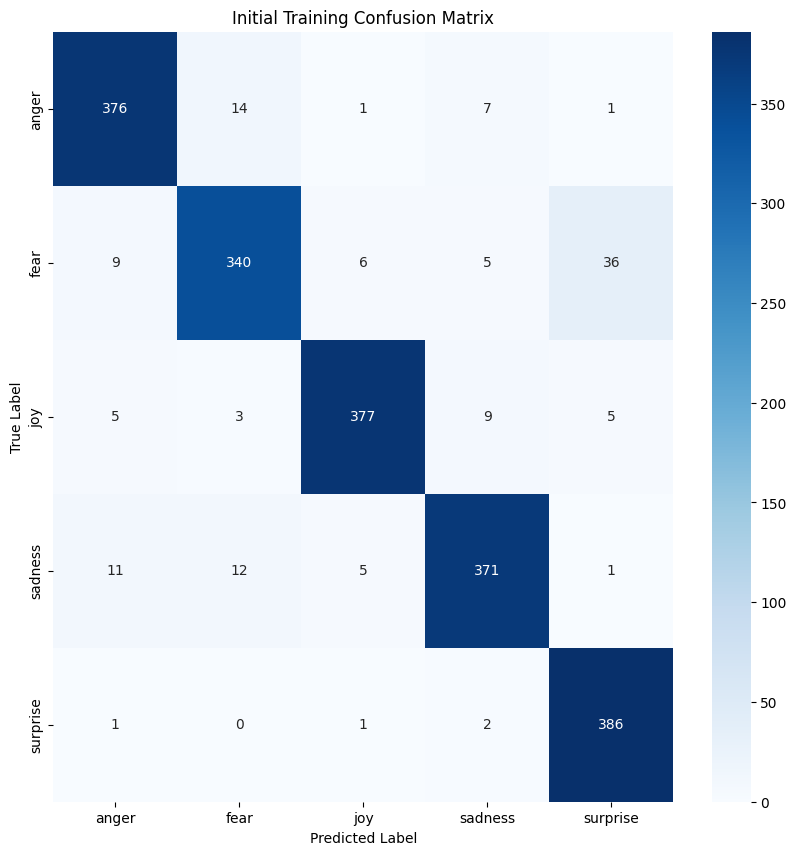

[[376  14   1   7   1]
 [  9 340   6   5  36]
 [  5   3 377   9   5]
 [ 11  12   5 371   1]
 [  1   0   1   2 386]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define label names so we can actually see the name of the emotion
label_names = ["anger", "fear", "joy", "sadness", "surprise"]

# Generate the confusion matrix
cm = confusion_matrix(labels, preds)

# Plot out the confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = label_names, yticklabels = label_names, cmap = "Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Initial Training Confusion Matrix')
plt.show()

print(cm)

# [[376  14   1   7   1]
#  [  9 340   6   5  36]
#  [  5   3 377   9   5]
#  [ 11  12   5 371   1]
#  [  1   0   1   2 386]]

# Hyperparameter Tuning

To do hyperparameter tuning for Hugging Face-type models, typically we'll use Optuna, so let's import it here:

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.5 MB/s eta 0:00:00


We need to define our hyperparameter space, which is the "range" of values for each hyperparameter we want to optimise. Here, we've decided to optimise the learning rate, training and evaluation batch sizes, scheduler type, number of training epochs, and weight decay. We can approximate the range of values we want to test, given that we also want to optimise the time we spend on hyperparameter tuning and not want to spend waiting for the search to finish forever.

In [ ]:
import optuna

def hyperparameter_space(trial):
    return {
        # Test the best learning rate
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log = True),

        # Test the best training and evaluation batch sizes
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [8, 16, 32]),

        # Test the best scheduler type
        "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine", "cosine_with_restarts", "polynomial"]),

        # Test the best number of epochs
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 3),

        # Test the best weight decay
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3)
    }

Now, we declare the best "trial" or set of hyperparameters, and initialise the hyperparameter search inside it using the Trainer object. We would like to optimise in the direction of maximising the evaluation F1 score, which we chose instead of evaluation accuracy because as we noted earlier, the emotions aren't technically distributed evenly due to the earlier data leakage issues. We limit the number of trials to save time.

In [ ]:
best_trial = trainer.hyperparameter_search(
    direction = "maximize",
    hp_space = hyperparameter_space,
    compute_objective = lambda metrics: metrics["eval_f1"],
    n_trials = 3 # Try more often so that the search is more thorough
)

[I 2025-06-23 08:21:23,842] A new study created in memory with name: no-name-2e994608-b696-4a22-b7f6-66de814ef399


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-06-23 08:24:12,759] Trial 0 finished with value: 0.9240630350961224 and parameters: {'learning_rate': 1.9303740448163156e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 16, 'lr_scheduler_type': 'polynomial', 'num_train_epochs': 2, 'weight_decay': 0.06721125327136364}. Best is trial 0 with value: 0.9240630350961224.


[I 2025-06-23 08:28:48,492] Trial 1 finished with value: 0.9303903836503267 and parameters: {'learning_rate': 4.595508340350927e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'lr_scheduler_type': 'cosine_with_restarts', 'num_train_epochs': 3, 'weight_decay': 0.2506723709397016}. Best is trial 1 with value: 0.9303903836503267.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-06-23 08:31:37,876] Trial 2 finished with value: 0.9229782703061544 and parameters: {'learning_rate': 1.3666925788138992e-05, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 8, 'lr_scheduler_type': 'polynomial', 'num_train_epochs': 2, 'weight_decay': 0.09743643666007556}. Best is trial 1 with value: 0.9303903836503267.


Now, with that done, we can print out the best trial's metrics.

In [ ]:
print(best_trial.hyperparameters)

# {'learning_rate': 4.595508340350927e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'lr_scheduler_type': 'cosine_with_restarts', 'num_train_epochs': 3, 'weight_decay': 0.2506723709397016}

{'learning_rate': 4.595508340350927e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'lr_scheduler_type': 'cosine_with_restarts', 'num_train_epochs': 3, 'weight_decay': 0.2506723709397016}


Now, we can finally update the training arguments using the best trial's hyperparameters.

In [ ]:
# Save the best trial's hyperparameters
# best_arguments = best_trial.hyperparameters

from transformers import Trainer, TrainingArguments

# Update the training argument with the best hyperparameters
training_arguments = TrainingArguments(
    output_dir = "./results_best",
    eval_strategy = "epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 32,
    num_train_epochs = 3,
    learning_rate = 4.595508340350927e-05,
    weight_decay = 0.2506723709397016,
    lr_scheduler_type = 'cosine_with_restarts'
)

Now, just reconstruct the trainer and let the base model train again.

In [ ]:
# Reconstruct the trainer
trainer = Trainer(
    model_init = model_init,
    args = training_arguments,
    train_dataset = split_finetuning_dataset["train"],
    eval_dataset = split_finetuning_dataset["test"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics_function
)

# Retrain the base model using the fine-tuned dataset AND the best hyperparameters found
trainer.train()

/tmp/ipython-input-40-2959580890.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 22002548siswa (22002548siswa-university-of-malaya) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=1497, training_loss=0.20014827475996916, metrics={'train_runtime': 657.4595, 'train_samples_per_second': 36.431, 'train_steps_per_second': 2.277, 'total_flos': 570496880149056.0, 'train_loss': 0.20014827475996916, 'epoch': 3.0})

# Checking of Loss, Accuracy, Precision, Recall, and F1 Scores

Now that we've initially fine-tuned the model to see what it's intitial metrics would look like, searched for the best hyperparameters using a hyperparameter search, and retrained the base model with the fine-tuning dataset AND the best hyperparameters, it's time to evaluate and see the final scores of the fine-tuned model that we've worked on so far.

In [ ]:
# Evaluate the model
trainer.evaluate()

# {'eval_loss': 0.24958954751491547,
#  'eval_accuracy': 0.9309475806451613,
#  'eval_f1': 0.9303903836503267,
#  'eval_precision': 0.9315673318144291,
#  'eval_recall': 0.9309475806451613,
#  'eval_runtime': 5.2745,
#  'eval_samples_per_second': 376.152,
#  'eval_steps_per_second': 11.755,
#  'epoch': 3.0}

{'eval_loss': 0.24958954751491547,
 'eval_accuracy': 0.9309475806451613,
 'eval_f1': 0.9303903836503267,
 'eval_precision': 0.9315673318144291,
 'eval_recall': 0.9309475806451613,
 'eval_runtime': 6.011,
 'eval_samples_per_second': 330.064,
 'eval_steps_per_second': 10.314,
 'epoch': 3.0}

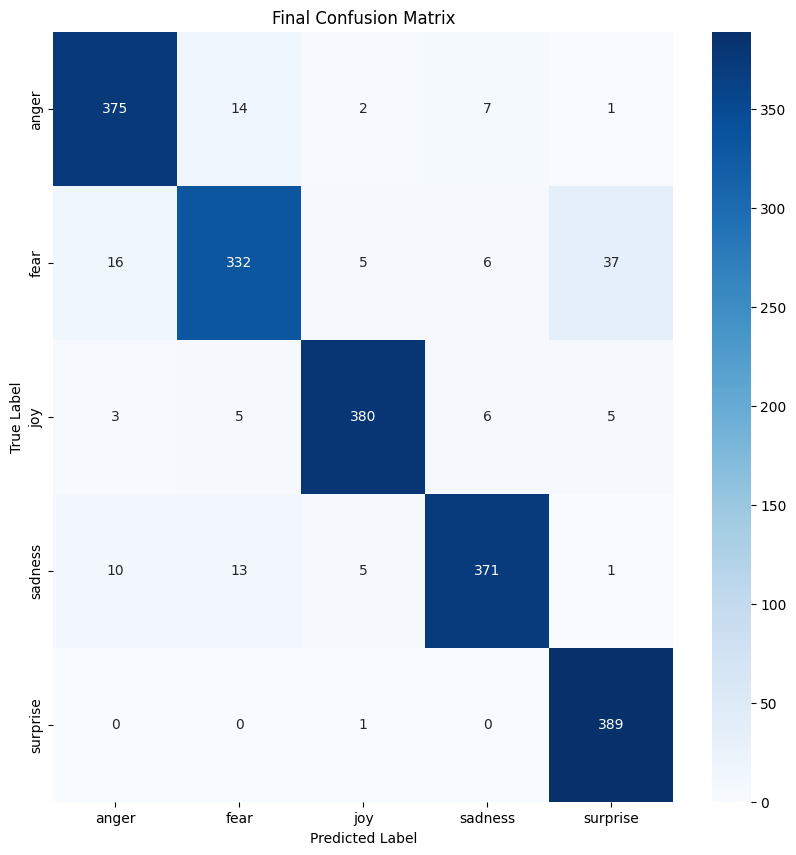

[[375  14   2   7   1]
 [ 16 332   5   6  37]
 [  3   5 380   6   5]
 [ 10  13   5 371   1]
 [  0   0   1   0 389]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions on the test set
predictions_output = trainer.predict(split_finetuning_dataset["test"])

# Extract predictions and true labels
preds = predictions_output.predictions.argmax(-1)
labels = predictions_output.label_ids

# Generate the confusion matrix again
cm = confusion_matrix(labels, preds)

label_names = ["anger", "fear", "joy", "sadness", "surprise"]

# Plot out the confusion matrix again
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = label_names, yticklabels = label_names, cmap = "Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Confusion Matrix')
plt.show()

print(cm)

# [[375  14   2   7   1]
#  [ 16 332   5   6  37]
#  [  3   5 380   6   5]
#  [ 10  13   5 371   1]
#  [  0   0   1   0 389]]

In [ ]:
# Save the final fine-tuned model and tokenizer into a directory
model.save_pretrained("final_fine_tuned_model")
tokenizer.save_pretrained("final_fine_tuned_model")

('final_fine_tuned_model/tokenizer_config.json',
 'final_fine_tuned_model/special_tokens_map.json',
 'final_fine_tuned_model/vocab.json',
 'final_fine_tuned_model/merges.txt',
 'final_fine_tuned_model/added_tokens.json',
 'final_fine_tuned_model/tokenizer.json')

In the end, we've managed to fine-tune the base model to have 29.64% evaluation loss, **~93% evaluation accuracy, 92.95% evaluation F1 score**, 93.07% evaluation precision, and ~93% evaluation recall. That's really good, considering the base model's evaluation accuracy was ***66%***! That's a **27%** increase or ***41% relative improvement*** over the base model's evaluation accuracy!

# Comparison with Other Models

In [ ]:
split_finetuning_dataset["test"]

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1984
})

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from datasets import Dataset

def evaluate_model(model_name, test_dataset):
    # Load model and tokenizer
    this_tokenizer = AutoTokenizer.from_pretrained(model_name)
    this_model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Get the labels that the current model was trained on
    model_labels = list(this_model.config.id2label.keys())

    # Filter the test dataset to include only the labels present in the model's label space
    filtered_test_dataset = test_dataset.filter(lambda x: x["label"] in model_labels)

    # Tokenize filtered test data
    def preprocess(example):
        return this_tokenizer(example["text"], truncation = True, padding = True)

    tokenized_test = filtered_test_dataset.map(preprocess, batched = True)

    # Create Trainer
    this_training_arguments = TrainingArguments(
    output_dir = "tmp",
    per_device_eval_batch_size = 32,
    do_train = False,
    do_eval = True,
    )

    this_trainer = Trainer(
        model = this_model,
        args = this_training_arguments,
        eval_dataset = tokenized_test,
        tokenizer = this_tokenizer
        )

    # Get raw predictions
    this_predictions = this_trainer.predict(tokenized_test)
    this_preds = np.argmax(this_predictions.predictions, axis = -1)
    this_labels = this_predictions.label_ids


    report = classification_report(
        this_labels,
        this_preds,
        target_names = list(this_model.config.id2label.values()),
        output_dict = True
    )

    # Print metrics
    print(f"\n Evaluation for {model_name}:")
    print(classification_report(this_labels, this_preds, target_names = list(this_model.config.id2label.values())))

    return report

# Compare models

raw_test_dataset = split_finetuning_dataset["test"].remove_columns(['input_ids', 'attention_mask'])

all_reports = {}

for model_name in [
    "final_fine_tuned_model",
    "j-hartmann/emotion-english-distilroberta-base",
    # "bhadresh-savani/distilbert-base-uncased-emotion",
    # "ayoubkirouane/BERT-Emotions-Classifier",
    # "nateraw/bert-base-uncased-emotion"
]:

    report = evaluate_model(model_name, raw_test_dataset)

    #print(report) # Commenting this out to avoid printing the full dictionary for each model

    all_reports[model_name] = report

Filter:   0%|          | 0/1984 [00:00<?, ? examples/s]

Map:   0%|          | 0/1984 [00:00<?, ? examples/s]

/tmp/ipython-input-47-2690159366.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  this_trainer = Trainer(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p


 Evaluation for final_fine_tuned_model:
              precision    recall  f1-score   support

       anger       0.89      0.90      0.90       399
     disgust       0.00      0.00      0.00         0
        fear       0.82      0.86      0.84       396
         joy       0.88      0.91      0.89       399
     neutral       0.00      0.00      0.00         0
     sadness       0.90      0.90      0.90       400
    surprise       0.92      0.81      0.86       390

    accuracy                           0.87      1984
   macro avg       0.63      0.62      0.63      1984
weighted avg       0.88      0.87      0.88      1984



Filter:   0%|          | 0/1984 [00:00<?, ? examples/s]

Map:   0%|          | 0/1984 [00:00<?, ? examples/s]

/tmp/ipython-input-47-2690159366.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  this_trainer = Trainer(



 Evaluation for j-hartmann/emotion-english-distilroberta-base:
              precision    recall  f1-score   support

       anger       0.89      0.90      0.90       399
     disgust       0.00      0.00      0.00         0
        fear       0.82      0.86      0.84       396
         joy       0.88      0.91      0.89       399
     neutral       0.00      0.00      0.00         0
     sadness       0.90      0.90      0.90       400
    surprise       0.92      0.81      0.86       390

    accuracy                           0.87      1984
   macro avg       0.63      0.62      0.63      1984
weighted avg       0.88      0.87      0.88      1984



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

# Packaging of Model into Gradio-Based Web Application

In [ ]:
# To load the final fine-tuned model and tokenizer later without running the cells above again:
!pip install transformers

In [ ]:
# Restore the final fine-tuned model and its tokenizer
# Make sure to create a folder titled "final_fine_tuned_model" and place the model and its files in that folder
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("./final_fine_tuned_model")
tokenizer = AutoTokenizer.from_pretrained("./final_fine_tuned_model")

In [ ]:
# Install the Gradio package
!pip install gradio

In [ ]:
# Ammar's version
import gradio as gr
import torch

def get_mood_text(label):
  match label:
    case "anger":
      label_description = "anger! 😡 Whoever wrote this may need something to calm down their nerves! 😌"
    case "disgust":
      label_description = "disgust! 🤢 The person that wrote this may need to physically get away from what is making them feel that way. 🏃💨"
    case "fear":
      label_description = "fear! 😱 The author of this may want to run from whatever is making them so scared! 😰"
    case "joy":
      label_description = "joy! 😁 Perhaps you should ask whoever wrote this about why they seem to be very happy? 😊"
    case "neutral":
      label_description = "neutrality. 😐 Unfortunately, it's uncertain what emotion the author is trying to say. You may to have to ask them yourself! 🫡"
    case "sadness":
      label_description = "sadness... 😭 You should definitely ask the author what's wrong, at least to give them a supporting hand. 🥺"
    case "surprise":
      label_description = "surprise! 😲 The author has probably caught themselves in something they least expected. 🤔"
    case _:
      label_description = "nothing... The model wasn't able to get a mood at all..."

  mood_text = f"This social media post most probably conveys a mood of {label_description}"

  return mood_text

def classify_mood(text):
    # Tokenize and classify the text
    inputs = tokenizer(text, return_tensors = "pt", truncation = True, padding = True)

    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]

    return get_mood_text(label)

In [ ]:
# Ammar's version
with gr.Blocks(css = """
/* Global App Background */
body {
    background-color: #f2f7f9;
    margin: 0;
    padding: 0;
    min-height: 100vh;
}

/* Main Container */
.gradio-container {
    padding: 2rem;
    max-width: 750px;
    margin: auto;
    background-color: #FFB6C1;
    border-radius: 1rem;
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.08);
    margin-top: 3rem;
    margin-bottom: 3rem;
}

/* Title and Description */
#main-title {
    font-size: 2.5rem;
    text-align: center;
    font-weight: 800;
    color: #ffffff;
    margin-bottom: 0.5rem;
    overflow: visible !important;
    resize: none !important;
}

#desc {
    text-align: center;
    font-size: 1.1rem;
    color: #e5e7eb;
    margin-bottom: 1.5rem;
    overflow: visible !important;
}

/* Input/Output Container */
.wrap {
    background-color: #f4f4f5 !important;
    border-radius: 1rem !important;
    padding: 1rem !important;
    border: 1px solid #ccc !important;
    box-shadow: 0 2px 6px rgba(0, 0, 0, 0.1) !important;
}

/* Text Inputs */
textarea, input[type="text"] {
    background-color: #f4f4f5 !important;
    color: #000000 !important;
    font-weight: 600 !important;
    border: 1px solid #cbd5e1 !important;
    border-radius: 0.5rem !important;
    padding: 0.75rem !important;
    font-size: 1rem !important;
    overflow-y: hidden !important;
}

/* Output Box */
.output-class textarea {
    background-color: #f4f4f5 !important;
    color: #111827 !important;
}

/* Labels */
label {
    color: #000000 !important;
    font-weight: 900 !important;
    font-size: 1.1rem !important;
}

/* Custom Button */
#analyse-button {
    background-color: #ec4899 !important;  /* Pink */
    color: white !important;
    font-weight: bold !important;
    border: none !important;
    border-radius: 0.5rem !important;
    padding: 0.75rem 1.5rem !important;
    box-shadow: 0 2px 6px rgba(0, 0, 0, 0.15) !important;
    transition: background-color 0.3s ease;
    margin-top: 1rem !important;
}

#analyse-button:hover {
    background-color: #db2777 !important;  /* Darker pink */
}

/* Hide Footer */
footer {
    display: none !important;
}
"""
) as demo:
    gr.Markdown("# 🧠 Social Media Mood Analyser 📈", elem_id = "main-title")
    gr.Markdown("Paste any text below to analyse its emotional tone 👇", elem_id = "desc")

    with gr.Row():
        textbox = gr.Textbox(
            lines = 3,
            placeholder = "Example: I'm feeling great today!",
            label = "Input Text"
        )

    mood_output = gr.Textbox(label = "Predicted Mood", interactive = False)
    analyse_button = gr.Button("Analyse Mood ⚙️")

    analyse_button.click(fn = classify_mood, inputs = textbox, outputs = mood_output)

demo.launch(share = True, debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f7a970407d669ff760.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f7a970407d669ff760.gradio.live


# **The End!**